# Stencil Computation for 2D Gray-Scott Using Julia 

In [1]:
#using Pkg
#Pkg.add("CUDA")

In [2]:
#import Pkg
#Pkg.add("BenchmarkTools")

In [3]:
#import Pkg
#Pkg.add("ProgressMeter")

In [4]:
#import Pkg
#Pkg.add("KernelAbstractions")

In [5]:
#import Pkg
#Pkg.add("Plots")
#Pkg.add("ColorTypes")

In [6]:
using CUDA # for NVIDIA GPU access

In [7]:
using BenchmarkTools # for benchmarking

In [8]:
using ProgressMeter # for progress monitoring

In [9]:
using Plots, ColorTypes # for plotting

When using CUDA.jl on a new system, you should always check if the package is functional as is able to utilize your GPUs correctly. To do this, you can call the `CUDA.versioninfo()` function. Like `Base.versioninfo()`, this will print some information on the available hardware and loaded libraries:

In [10]:
CUDA.versioninfo()

CUDA runtime 12.6, artifact installation
CUDA driver 12.4
NVIDIA driver 550.54.15

CUDA libraries: 
- CUBLAS: 12.6.3
- CURAND: 10.3.7
- CUFFT: 11.3.0
- CUSOLVER: 11.7.1
- CUSPARSE: 12.5.4
- CUPTI: 2024.3.2 (API 24.0.0)
- NVML: 12.0.0+550.54.15

Julia packages: 
- CUDA: 5.5.2
- CUDA_Driver_jll: 0.10.3+0
- CUDA_Runtime_jll: 0.15.3+0

Toolchain:
- Julia: 1.10.6
- LLVM: 15.0.7

3 devices:
  0: Tesla V100S-PCIE-32GB (sm_70, 31.729 GiB / 32.000 GiB available)
  1: Tesla P100-PCIE-16GB (sm_60, 15.886 GiB / 16.000 GiB available)
  2: NVIDIA GeForce GTX 1080 Ti (sm_61, 10.899 GiB / 11.000 GiB available)


# Gray-Scott Reaction-Diffusion Model

The Gray-Scott Reaction-Diffusion model is a mathematical model used to describe how two interacting substances, typically denoted as $U$ and $V$, evolve over time in a spatial domain. This model captures the combined effects of chemical reactions and diffusion, leading to complex pattern formations such as spots, stripes, and waves, which resemble natural phenomena like animal skin patterns or chemical reactions in a petri dish.

## Equations

The evolution of $ U $ and $ V $ over time is described by the following partial differential equations (PDEs):

$$
\frac{\partial U}{\partial t} = D_u \nabla^2 U - UV^2 + F(1 - U)
$$

$$
\frac{\partial V}{\partial t} = D_v \nabla^2 V + UV^2 - (F + k)V
$$

- **$D_u$**: Diffusion coefficient of $U$, controlling its spread rate.
- **$D_v$**: Diffusion coefficient of $V$, controlling its spread rate.
- **$F$**: Feed rate of  $U$, representing the replenishment of  $U$ in the system.
- **$ k $**: Kill rate of $V$, representing the removal of $V$ from the system.
- **$ \nabla^2 $**: Laplacian operator, representing the diffusion term.

# 2D 5-Point Stencil in the Gray-Scott Reaction-Diffusion Model

The 2D 5-point stencil is used to compute the diffusion terms ($ D_u \nabla^2 U $ and $ D_v \nabla^2 V $) in the Gray-Scott reaction-diffusion equations. It helps model how the substances $ U $ and $V $ spread through the 2D spatial domain by capturing the local flow of concentration between neighboring points.



## Mathematical Formulation

The Laplacian of a function $ u $ at point $(i, j)$ using the 2D 5-point stencil is approximated as:



$$
\nabla^2 u_{i, j} \approx \frac{1}{h^2} \left( u_{i-1, j} + u_{i+1, j} - 2 \cdot u_{i, j} \right) + \frac{1}{h^2} \left( u_{i, j-1} + u_{i, j+1} - 2 \cdot u_{i, j} \right)
$$

- **$ h $** is the grid spacing.
- The approximation relies on the difference between the central point and its neighbors, scaled by the grid spacing.

## CPU (Single-Threaded) Implementation of the Gray-Scott Equation

In [11]:
function laplacian(A, x, y, dx)
    @inbounds DAx = (A[x-1, y] - 2.0 * A[x, y] + A[x+1, y]) / dx
    @inbounds DAy = (A[x, y-1] - 2.0 * A[x, y] + A[x, y+1]) / dx
    return DAx + DAy
end

laplacian (generic function with 1 method)

In [12]:
function calculate_gs_cpu!(U, V, D_u, D_v, F, k, dt, dx, nx, ny)
    # Allocate some temporary arrays for Laplacian results
    ΔU = zeros(nx, ny)
    ΔV = zeros(nx, ny)

    # Compute diffusion
    for x in 2:(nx-1), y in 2:(ny-1)
        @inbounds ΔU[x, y] = laplacian(U, x, y, dx)
        @inbounds ΔV[x, y] = laplacian(V, x, y, dx)
    end

    # Compute and update concentration fields
    UVV = U .* V .* V
    U .+= (D_u .* ΔU .- UVV .+ F .* (1 .- U)) .* dt
    V .+= (D_v .* ΔV .+ UVV .- (F .+ k) .* V) .* dt
    
    return
end
function simulate_gs_cpu(n = 500 #=Grid size=#, nsteps = 10000 #=Number of iterations=#)
    # Initialize parameters
    D_u = 0.16         # Diffusion rate of U
    D_v = 0.08         # Diffusion rate of V
    F = 0.035          # Feed rate
    k = 0.06           # Kill rate
    dt = 1.0           # Time step
    dx = 1.0           # Spatial step
    plot_every = 500   # Plot every 500 steps
    
    # Initialize concentration fields U and V
    U = rand(0.0:0.001:0.1, n, n)
    V = zeros(n, n)

    # Set up an initial small disturbance
    n_mid = div(n, 2)
    U[n_mid-5:n_mid+5, n_mid-5:n_mid+5] .= 0.5
    V[n_mid-5:n_mid+5, n_mid-5:n_mid+5] .= 0.25

    # Set up a progress bar
    prog = Progress(div(nsteps, plot_every))

    # Set up a figure for the heatmaps
    plt = Plots.plot(title="Gray-Scott Model", xlabel="X", ylabel="Y", size=(600, 600))

    # Simulation loop
    anim = Plots.@animate for T in 1:div(nsteps, plot_every)
        # Update the U and V concentrations
        for t in 1:plot_every
            calculate_gs_cpu!(U, V, D_u, D_v, F, k, dt, dx, n, n)
        end
        
        # Update the progress bar
        next!(prog)

        # Plot the current U concentrations
        Plots.heatmap!(plt, U, color=cgrad([:black, :blue, :white]), clims=(0, 1), title="Gray-Scott Model")
    end
    gif(anim, "gs_cpu_serial.gif"; fps=10)
end

simulate_gs_cpu (generic function with 3 methods)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


101.025856 seconds (425.98 M allocations: 69.430 GiB, 3.03% gc time, 6.12% compilation time: 30% of which was recompilation)


[ Info: Saved animation to /home/jpsamaroo/julia-hpc-tutorial-sc24/parts/gpu/gs_cpu_serial.gif


Plots.AnimatedGif("/home/jpsamaroo/julia-hpc-tutorial-sc24/parts/gpu/gs_cpu_serial.gif")
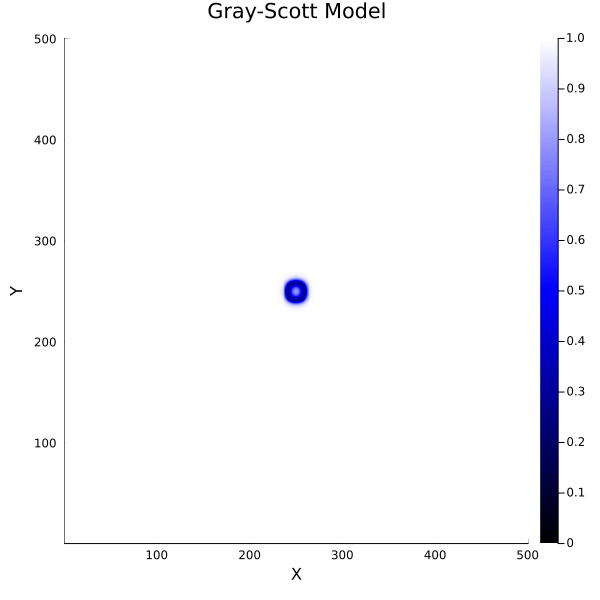

In [13]:
@time simulate_gs_cpu(500, 10000)

## CPU (Multi-Threaded) Implementation of the Gray-Scott Equation

In [14]:
function calculate_gs_cpu_mt!(U, V, D_u, D_v, F, k, dt, dx, nx, ny)
    # Allocate U and V temporaries for updates
    DU = Matrix{Float64}(undef, nx, ny)
    DV = Matrix{Float64}(undef, nx, ny)

    # Compute diffusion and concentration fields changes
    Threads.@threads for y in 2:(ny-1)
        for x in 2:(nx-1)
            # Compute diffusion
            ΔU = laplacian(U, x, y, dx)
            ΔV = laplacian(V, x, y, dx)

            # Compute concentration fields changes
            UVV = @inbounds U[x, y] * (V[x, y] ^ 2)
            @inbounds DU[x, y] = D_u * ΔU - UVV + F * (1 - U[x, y])
            @inbounds DV[x, y] = D_v * ΔV + UVV - (F + k) * V[x, y]
        end
    end

    # Update concentration fields
    Threads.@threads for y in 2:(ny-1)
        for x in 2:(nx-1)
            @inbounds U[x, y] += DU[x, y] * dt
            @inbounds V[x, y] += DV[x, y] * dt
        end
    end
    
    return
end
function simulate_gs_cpu_mt(n = 500 #=Grid size=#, nsteps = 10000 #=Number of iterations=#)
    # Initialize parameters
    D_u = 0.16         # Diffusion rate of U
    D_v = 0.08         # Diffusion rate of V
    F = 0.035          # Feed rate
    k = 0.06           # Kill rate
    dt = 1.0           # Time step
    dx = 1.0           # Spatial step
    plot_every = 500   # Plot every 500 steps
    
    # Initialize concentration fields U and V
    U = rand(0.0:0.001:0.1, n, n)
    V = zeros(n, n)

    # Set up an initial small disturbance
    n_mid = div(n, 2)
    U[n_mid-5:n_mid+5, n_mid-5:n_mid+5] .= 0.5
    V[n_mid-5:n_mid+5, n_mid-5:n_mid+5] .= 0.25

    # Set up a progress bar
    prog = Progress(div(nsteps, plot_every))

    # Set up a figure for the heatmaps
    plt = Plots.plot(title="Gray-Scott Model", xlabel="X", ylabel="Y", size=(600, 600))

    # Simulation loop
    anim = Plots.@animate for T in 1:div(nsteps, plot_every)
        # Update the U and V concentrations
        for t in 1:plot_every
            calculate_gs_cpu_mt!(U, V, D_u, D_v, F, k, dt, dx, n, n)
        end
        
        # Update the progress bar
        next!(prog)

        # Plot the current U concentrations
        Plots.heatmap!(plt, U, color=cgrad([:black, :blue, :white]), clims=(0, 1), title="Gray-Scott Model")
    end
    gif(anim, "gs_cpu_mt.gif"; fps=10)
end

simulate_gs_cpu_mt (generic function with 3 methods)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


 59.640621 seconds (420.44 M allocations: 50.430 GiB, 3.02% gc time, 0.32% compilation time)


[ Info: Saved animation to /home/jpsamaroo/julia-hpc-tutorial-sc24/parts/gpu/gs_cpu_mt.gif


Plots.AnimatedGif("/home/jpsamaroo/julia-hpc-tutorial-sc24/parts/gpu/gs_cpu_mt.gif")
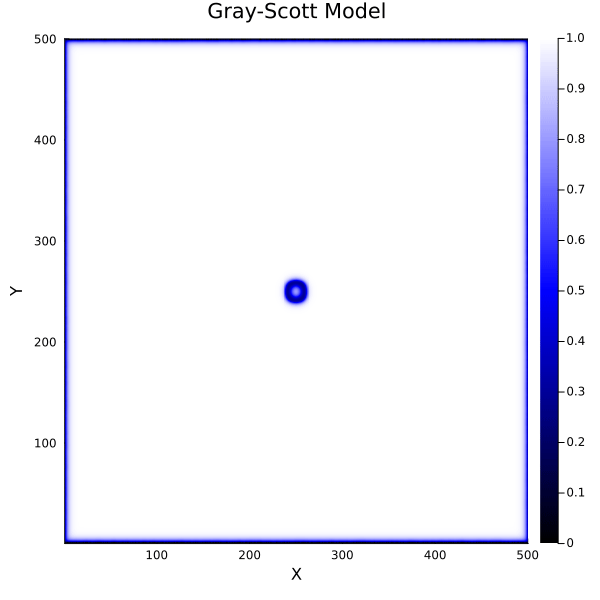

In [15]:
@time simulate_gs_cpu_mt(500, 10000)

## GPU (CUDA) Implementation of the Gray-Scott Equation

In [16]:
function calculate_gs_cuda!(U, V, D_u, D_v, F, k, dt, dx, nx, ny)
    x = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    y = (blockIdx().y - 1) * blockDim().y + threadIdx().y

    # Skip ghost cells on the boundaries
    if (1 < x < nx) && (1 < y < ny)
        # Compute diffusion
        ΔU = laplacian(U, x, y, dx)
        ΔV = laplacian(V, x, y, dx)

        # Update concentration fields
        UVV = @inbounds U[x, y] * (V[x, y] ^ 2)
        DU = @inbounds D_u * ΔU - UVV + F * (1 - U[x, y])
        DV = @inbounds D_v * ΔV + UVV - (F + k) * V[x, y]

        # Wait for all threads to read U and V
        CUDA.sync_threads()

        # Update concentration fields
        @inbounds U[x, y] += DU * dt
        @inbounds V[x, y] += DV * dt

        # Wait for all threads to write U and V
        CUDA.sync_threads()
    end
    
    return
end
function simulate_gs_cuda(n = 500 #=Grid size=#, nsteps = 10000 #=Number of iterations=#)
    # Initialize parameters
    D_u = 0.16         # Diffusion rate of U
    D_v = 0.08         # Diffusion rate of V
    F = 0.035          # Feed rate
    k = 0.06           # Kill rate
    dt = 1.0           # Time step
    dx = 1.0           # Spatial step
    plot_every = 500   # Plot every 500 steps
    
    # Initialize concentration fields U and V
    U = rand(0.0:0.001:0.1, n, n)
    V = zeros(n, n)

    # Set up an initial small disturbance
    n_mid = div(n, 2)
    U[n_mid-5:n_mid+5, n_mid-5:n_mid+5] .= 0.5
    V[n_mid-5:n_mid+5, n_mid-5:n_mid+5] .= 0.25
    
    # Transfer to the GPU
    U_gpu = CuArray(U)
    V_gpu = CuArray(V)

    # Set up a progress bar
    prog = Progress(div(nsteps, plot_every))

    # Set up a figure for the heatmaps
    plt = Plots.plot(title="Gray-Scott Model", xlabel="X", ylabel="Y", size=(600, 600))

    # Simulation loop
    anim = Plots.@animate for T in 1:div(nsteps, plot_every)
        # Update the U and V concentrations
        for t in 1:plot_every
            @cuda threads=(16, 16) blocks=(cld(n, 16), cld(n, 16)) calculate_gs_cuda!(U_gpu, V_gpu, D_u, D_v, F, k, dt, dx, n, n)
        end
        U_cpu = Array(U_gpu)
        
        # Update the progress bar
        next!(prog)

        # Plot the current U concentrations
        Plots.heatmap!(plt, U_cpu, color=cgrad([:black, :blue, :white]), clims=(0, 1), title="Gray-Scott Model")
    end
    gif(anim, "gs_cuda.gif"; fps=10)
end

simulate_gs_cuda (generic function with 3 methods)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


 38.800887 seconds (424.59 M allocations: 13.486 GiB, 3.99% gc time, 22.88% compilation time: 7% of which was recompilation)


[ Info: Saved animation to /home/jpsamaroo/julia-hpc-tutorial-sc24/parts/gpu/gs_cuda.gif


Plots.AnimatedGif("/home/jpsamaroo/julia-hpc-tutorial-sc24/parts/gpu/gs_cuda.gif")
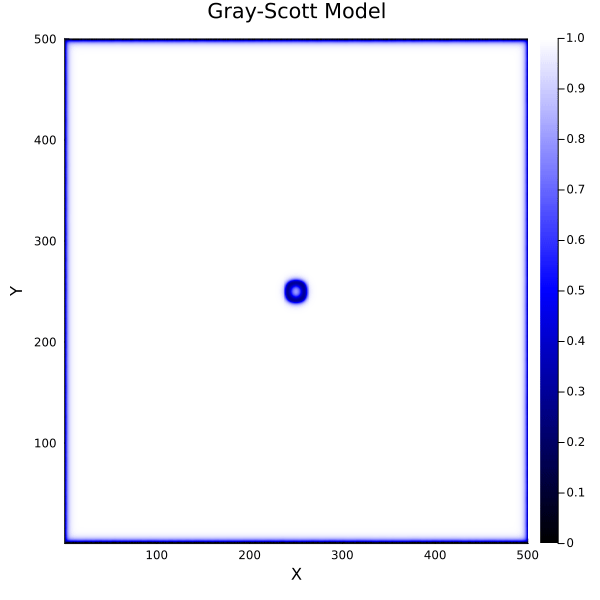

In [17]:
@time simulate_gs_cuda(500, 10000)

## GPU (KernelAbstractions) Implementation of the Gray-Scott Equation

In [18]:
using KernelAbstractions

In [19]:
# add all options for different backends and array types
DEV = :NVIDIA

if DEV == :NVIDIA
    using CUDA
    ArrayKA = CUDA.CuArray
    Backend = CUDA.CUDABackend()
elseif DEV == :AMD
    using AMDGPU
    ArrayKA = AMDGPU.ROCArray
    Backend = AMDGPU.ROCBackend()
elseif DEV == :oneAPI
    using oneAPI 
    ArrayKA = oneAPI.oneArray
    Backend = oneAPI.oneAPIBackend()
elseif DEV == :Metal
    using Metal 
    ArrayKA = Metal.MtlArray
    Backend = Metal.MetalBackend()
else DEV == :CPU
    ArrayKA = Array
    Backend = CPU()
end

CUDABackend(false, false)

In [20]:
@kernel function calculate_gs_ka!(U, V, D_u, D_v, F, k, dt, dx, nx, ny)
    x, y = @index(Global, NTuple)[1:2]

    # Skip ghost cells on the boundaries
    if (1 < x < nx) && (1 < y < ny)
        # Compute diffusion
        ΔU = laplacian(U, x, y, dx)
        ΔV = laplacian(V, x, y, dx)

        # Update concentration fields
        UVV = @inbounds U[x, y] * (V[x, y] ^ 2)
        DU = @inbounds D_u * ΔU - UVV + F * (1 - U[x, y])
        DV = @inbounds D_v * ΔV + UVV - (F + k) * V[x, y]

        # Wait for all threads to read U and V
        @synchronize()

        # Update concentration fields
        @inbounds U[x, y] += DU * dt
        @inbounds V[x, y] += DV * dt

        # Wait for all threads to write U and V
        @synchronize()
    end
    
    # No return, KernelAbstractions doesn't allow these right now
end
function simulate_gs_ka(n = 500 #=Grid size=#, nsteps = 10000 #=Number of iterations=#)
    # Initialize parameters
    D_u = 0.16         # Diffusion rate of U
    D_v = 0.08         # Diffusion rate of V
    F = 0.035          # Feed rate
    k = 0.06           # Kill rate
    dt = 1.0           # Time step
    dx = 1.0           # Spatial step
    plot_every = 500   # Plot every 500 steps
    
    # Initialize concentration fields U and V
    U = rand(0.0:0.001:0.1, n, n)
    V = zeros(n, n)

    # Set up an initial small disturbance
    n_mid = div(n, 2)
    U[n_mid-5:n_mid+5, n_mid-5:n_mid+5] .= 0.5
    V[n_mid-5:n_mid+5, n_mid-5:n_mid+5] .= 0.25
    
    # Transfer to the GPU
    U_gpu = KernelAbstractions.allocate(Backend, Float64, n, n)
    V_gpu = KernelAbstractions.allocate(Backend, Float64, n, n)
    KernelAbstractions.copyto!(Backend, U_gpu, U)
    KernelAbstractions.copyto!(Backend, V_gpu, V)
    
    # Compile KA kernel
    kernel = calculate_gs_ka!(Backend, (cld(n, 16), cld(n, 16)))

    # Set up a progress bar
    prog = Progress(div(nsteps, plot_every))

    # Set up a figure for the heatmaps
    plt = Plots.plot(title="Gray-Scott Model", xlabel="X", ylabel="Y", size=(600, 600))

    # Simulation loop
    anim = Plots.@animate for T in 1:div(nsteps, plot_every)
        # Update the U and V concentrations
        for t in 1:plot_every
            kernel(U_gpu, V_gpu, D_u, D_v, F, k, dt, dx, n, n, ndrange=(n, n))
        end

        # Copy U results back to CPU array and synchronize
        KernelAbstractions.copyto!(Backend, U, U_gpu)
        KernelAbstractions.synchronize(Backend)
        
        # Update the progress bar
        next!(prog)

        # Plot the current U concentrations
        Plots.heatmap!(plt, U, color=cgrad([:black, :blue, :white]), clims=(0, 1), title="Gray-Scott Model")
    end
    gif(anim, "gs_ka.gif"; fps=10)
end

simulate_gs_ka (generic function with 3 methods)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:30


 34.222204 seconds (423.21 M allocations: 13.344 GiB, 5.58% gc time, 11.11% compilation time)


[ Info: Saved animation to /home/jpsamaroo/julia-hpc-tutorial-sc24/parts/gpu/gs_ka.gif


Plots.AnimatedGif("/home/jpsamaroo/julia-hpc-tutorial-sc24/parts/gpu/gs_ka.gif")
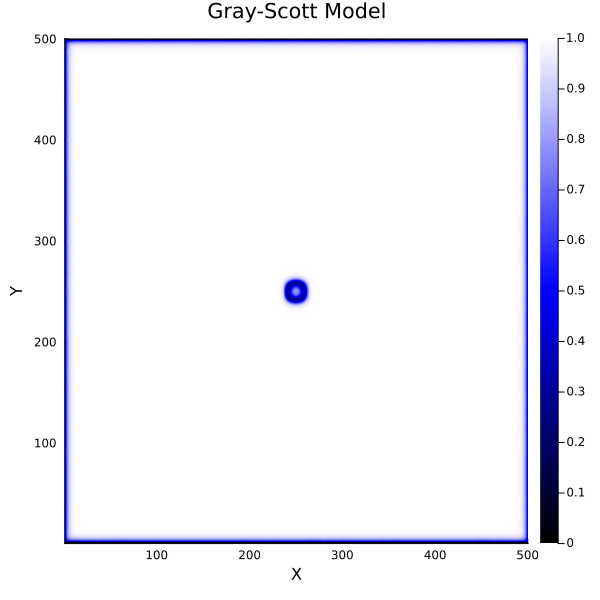

In [21]:
@time simulate_gs_ka(500, 10000)